### Dataset preparation    
- convert glacier vector to glacier image.


In [1]:
import glob
import os
import re 
import numpy as np
import geopandas as gpd
import rasterio as rio 
from rasterio import features
import matplotlib.pyplot as plt
from utils.imgShow import imgShow


In [2]:
pattern = re.compile(r'[a-zA-Z]\d_scene_(\d+)')
all_truth_paths = sorted(glob.glob('data/truth/*.gpkg'))

paths_truth_vec_tra = []
paths_truth_vec_val = []

paths_dem_tra = []
paths_dem_val = []

for path in all_truth_paths:
    filename = os.path.basename(path) 
    
    match = pattern.search(filename) 
    
    if match:
        scene_number_str = match.group(1) 
        scene_number = int(scene_number_str) 
        if scene_number >= 11:
            paths_truth_vec_val.append(path)
        else:
            paths_truth_vec_tra.append(path)

paths_scene_tra = [p.replace('.gpkg', '.tif').replace('truth', 'scene') for p in paths_truth_vec_tra]
paths_scene_val = [p.replace('.gpkg', '.tif').replace('truth', 'scene') for p in paths_truth_vec_val]

paths_dem_tra = [p.replace('.gpkg', '_DEM.tif').replace('truth', 'dem') for p in paths_truth_vec_tra]
paths_dem_val = [p.replace('.gpkg', '_DEM.tif').replace('truth', 'dem') for p in paths_truth_vec_val]

print(f"\nTotal files found: {len(all_truth_paths)}")
print(f"Training scene image count: {len(paths_scene_tra)}")
print(f"Validation scene image count: {len(paths_scene_val)}")
print(paths_scene_tra[0])


Total files found: 65
Training scene image count: 50
Validation scene image count: 15
data/scene/S2_scene_01.tif


In [3]:
# ### get the labeled landsat and sentinel images
# paths_truth_vec_tra = sorted(glob.glob('data/dset-l5789-s2/tra_truth/*.gpkg'))
# paths_scene_tra = [path_truth_vec.replace('.gpkg', '_Dem.tif').replace('truth','scene') for path_truth_vec in paths_truth_vec_tra]

# paths_truth_vec_val = sorted(glob.glob('data/dset-l5789-s2/val_truth/*.gpkg'))
# paths_scene_val = [path_truth_vec.replace('.gpkg', '_Dem.tif').replace('truth','scene') for path_truth_vec in paths_truth_vec_val]
# print(len(paths_scene_tra))
# print(len(paths_scene_val))

In [4]:
## check the scene images and the truth vector
id_dset = 10
scene_rio = rio.open(paths_scene_tra[id_dset])
truth_vec_gpd = gpd.read_file(paths_truth_vec_tra[id_dset])
scene_extent = [scene_rio.bounds.left, scene_rio.bounds.right, scene_rio.bounds.bottom, scene_rio.bounds.top]
print(paths_scene_tra[id_dset], paths_truth_vec_tra[id_dset])
 

data/scene/l5_scene_01.tif data/truth/l5_scene_01.gpkg


<Axes: >

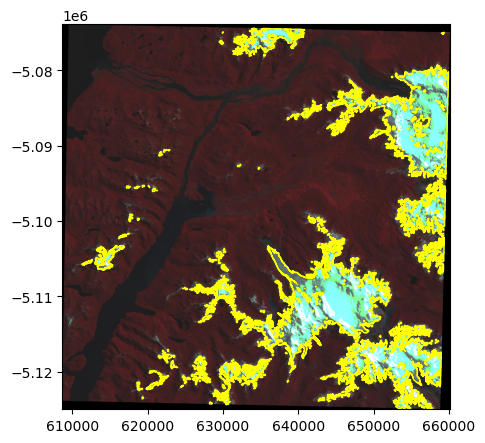

In [5]:
if scene_rio.crs != truth_vec_gpd.crs:
  print('crs transformation needed')
  truth_vec_gpd = truth_vec_gpd.to_crs(scene_rio.crs.to_dict())
## show the scene and the truth vector
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
imgShow(scene_rio.read([2,3,4]).transpose(1,2,0), ax=ax,  extent=scene_extent)
truth_vec_gpd.plot(ax=ax, color='none', edgecolor='yellow', linewidth=1) 


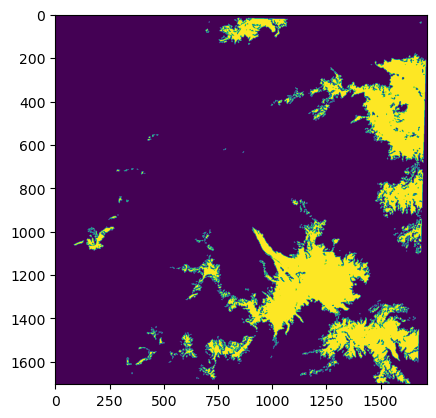

In [6]:
###  create a mask from the truth vector
def create_mask_from_vec(img_rio, vec_gpd):
    if vec_gpd.crs != img_rio.crs:
        vec_gpd = vec_gpd.to_crs(img_rio.crs.to_dict())
    shapes = [(geom, 1) for geom in vec_gpd.geometry if geom is not None and not geom.is_empty]

    mask_water = features.rasterize(
        shapes=shapes,
        out_shape=(img_rio.height, img_rio.width),
        transform=img_rio.transform,
        all_touched=False,
        default_value=1,
        fill=0,
        dtype=np.uint8)
    return mask_water

mask_water = create_mask_from_vec(img_rio = scene_rio, vec_gpd=truth_vec_gpd)
plt.imshow(mask_water) 


In [7]:
## write the mask to a geotiff
path_truth_gpkg = paths_truth_vec_tra[id_dset]
path_truth_img = path_truth_gpkg.replace('.gpkg', '.tif')

def write_mask_to_geotiff(mask, scene_rio, path_save):
    mask_meta = scene_rio.meta.copy()
    mask_meta.update({
        'dtype': 'uint8',
        'count': 1,
        'compress': 'lzw',
        'nodata': 0
    })
    
    with rio.open(path_save, 'w', **mask_meta) as dst:
        dst.write(mask, 1)
    print('mask written to', path_save)

write_mask_to_geotiff(mask = mask_water, scene_rio=scene_rio, path_save = path_truth_img)


mask written to data/truth/l5_scene_01.tif


In [8]:
## convert the .gpkg vector to .tiff truth image.
for i, path_truth_vec in enumerate(paths_truth_vec_tra):
    truth_vec_gpd = gpd.read_file(path_truth_vec)
    scene_rio = rio.open(paths_scene_tra[i])
    ### generate water mask
    if scene_rio.crs != truth_vec_gpd.crs:
        truth_vec_gpd = truth_vec_gpd.to_crs(scene_rio.crs.to_dict())
    mask_water = create_mask_from_vec(img_rio = scene_rio, 
                                        vec_gpd=truth_vec_gpd)
    ### write the water mask to a geotiff
    path_truth_img = path_truth_vec.replace('.gpkg', '.tif')
    write_mask_to_geotiff(mask = mask_water, scene_rio=scene_rio, 
                                        path_save = path_truth_img)
    scene_rio.close()


mask written to data/truth/S2_scene_01.tif
mask written to data/truth/S2_scene_02.tif
mask written to data/truth/S2_scene_03.tif
mask written to data/truth/S2_scene_04.tif
mask written to data/truth/S2_scene_05.tif
mask written to data/truth/S2_scene_06.tif
mask written to data/truth/S2_scene_07.tif
mask written to data/truth/S2_scene_08.tif
mask written to data/truth/S2_scene_09.tif
mask written to data/truth/S2_scene_10.tif
mask written to data/truth/l5_scene_01.tif
mask written to data/truth/l5_scene_02.tif
mask written to data/truth/l5_scene_03.tif
mask written to data/truth/l5_scene_04.tif
mask written to data/truth/l5_scene_05.tif
mask written to data/truth/l5_scene_06.tif
mask written to data/truth/l5_scene_07.tif
mask written to data/truth/l5_scene_08.tif
mask written to data/truth/l5_scene_09.tif
mask written to data/truth/l5_scene_10.tif
mask written to data/truth/l7_scene_01.tif
mask written to data/truth/l7_scene_02.tif
mask written to data/truth/l7_scene_03.tif
mask writte

In [9]:
## convert the .gpkg vector to .tiff truth image.
for i, path_truth_vec in enumerate(paths_truth_vec_val):
    truth_vec_gpd = gpd.read_file(path_truth_vec)
    scene_rio = rio.open(paths_scene_val[i])
    ### generate water mask
    if scene_rio.crs != truth_vec_gpd.crs:
        truth_vec_gpd = truth_vec_gpd.to_crs(scene_rio.crs.to_dict())
    mask_water = create_mask_from_vec(img_rio = scene_rio, 
                                        vec_gpd=truth_vec_gpd)
    ### write the water mask to a geotiff
    path_truth_img = path_truth_vec.replace('.gpkg', '.tif')
    write_mask_to_geotiff(mask = mask_water, scene_rio=scene_rio, 
                                        path_save = path_truth_img)
    scene_rio.close()

mask written to data/truth/S2_scene_11.tif
mask written to data/truth/S2_scene_12.tif
mask written to data/truth/S2_scene_13.tif
mask written to data/truth/l5_scene_11.tif
mask written to data/truth/l5_scene_12.tif
mask written to data/truth/l5_scene_13.tif
mask written to data/truth/l7_scene_11.tif
mask written to data/truth/l7_scene_12.tif
mask written to data/truth/l7_scene_13.tif
mask written to data/truth/l8_scene_11.tif
mask written to data/truth/l8_scene_12.tif
mask written to data/truth/l8_scene_13.tif
mask written to data/truth/l9_scene_11.tif
mask written to data/truth/l9_scene_12.tif
mask written to data/truth/l9_scene_13.tif
